In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import os
import shutil
from tqdm import tqdm
datapaths = glob.glob('data/*.txt')

datas = []

for datapath in datapaths:
    d = pd.read_csv(datapath)
    datas.append(d.values)

In [41]:
def compute_principle_components(D):
# Assume that D is a matrix of shape N x M, where N denotes the
# number of sample data points in a dataset and M denotes the feature dimension. Here, D
# represents a particular dataset. Perform the PCA of D using the Singular Value Decomposition (SVD)
# technique that you learned and used in Assignment-1. Keep in mind that you have to perform PCA
# only when M > 2. If M <= 2, then you can directly plot the data points in a 2D plane without performing
# PCA.
    print(f"Computing PCA for dataset of size {D.shape}")
    N, M = D.shape
    if M <= 2:
        return D
    else:
        # Compute the mean of each column
        D_mean = np.mean(D, axis=0)

        # Subtract the mean from each column
        D = D - D_mean

        # Compute the covariance matrix
        D_cov = np.cov(D, rowvar=False)

        # Apply svd
        U, S, V = np.linalg.svd(D_cov, full_matrices=True)
        
        # Sort the eigenvalues in descending order
        idx = S.argsort()[::-1]
        S = S[idx]
        U = U[:,idx]
        
        # Compute the projection matrix
        P = U[:,:2]
        
        # Project the data
        D = np.dot(D, P)
        
        return D
def plot_data(D, title):
    #Plot the data points along
    #two principal axes (if PCA is applied) or along two feature dimensions (if PCA is not applied). This
    #plot may look like the following one. You should store the plot as an image file
    
    plt.scatter(D[:,0], D[:,1], s=1)
    plt.title(title)
    plt.savefig(os.path.join('figures', f'pca_{title}' + '.png'), bbox_inches='tight', dpi=300)
    plt.show()
    
def run_and_save_pca_plot(D, title):
    D = compute_principle_components(D)
    plot_data(D, title)

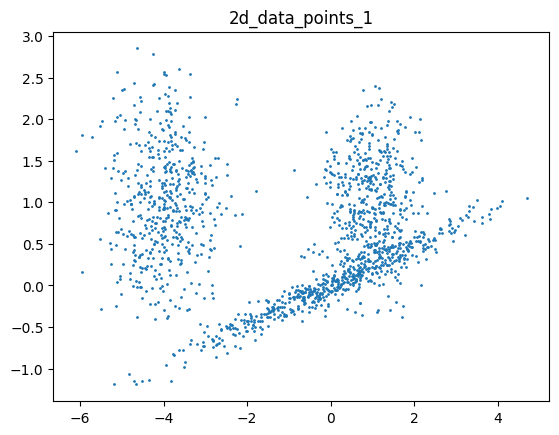

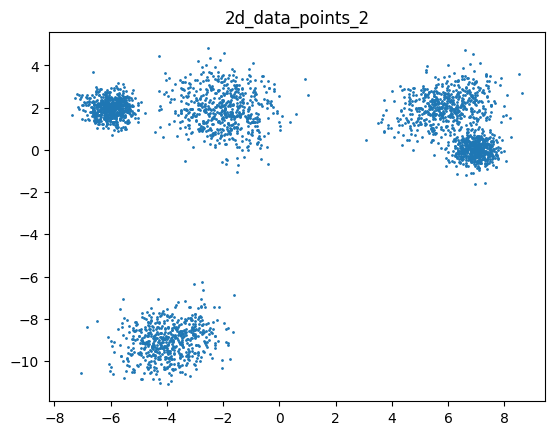

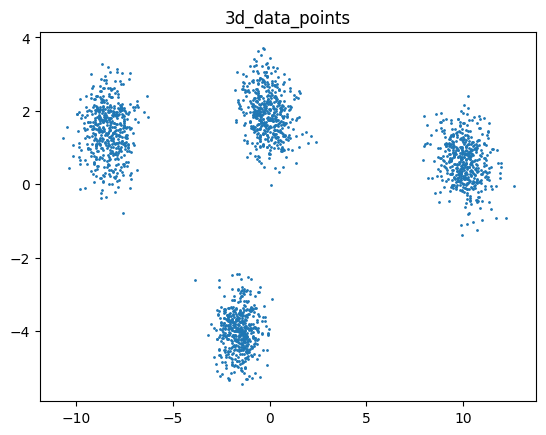

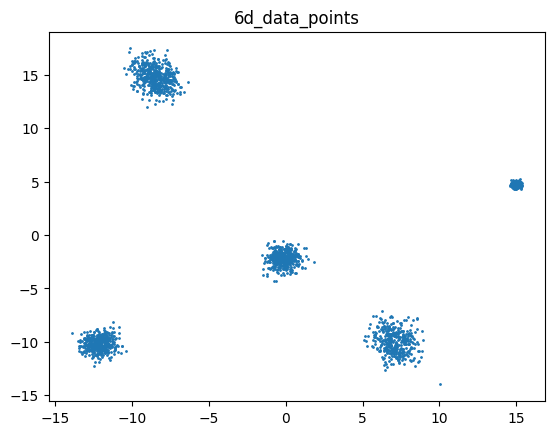

In [3]:
filenames = ['2d_data_points_1', '2d_data_points_2', '3d_data_points', '6d_data_points']
if not os.path.exists('figures'):
    os.makedirs('figures')
for d, filename in zip(datas, filenames):
    run_and_save_pca_plot(d, filename)

In [42]:
def log_likelihood(X, weights, means, covariances):
    n, d = X.shape
    K = len(weights)
    ll = 0
    s = 0
    for k in range(K):
        pdf_X = 1 / np.sqrt(np.linalg.det(covariances[k]) * (2 * np.pi) ** d) * np.exp(-0.5 * np.sum((X - means[k]) * np.dot(np.linalg.inv(covariances[k]), (X - means[k]).T).T, axis=1))
        s += weights[k] * pdf_X
    ll = np.sum(np.log(s))
    return ll
def GMM_EM_optimized(X, K, max_iters=1000):
    n, d = X.shape # n: number of data points, d: dimension of data points
    weights = np.random.rand(K) # These are the initial weights for the K GMM components, size (K,)
    weights = weights / np.sum(weights) # We normalize so they sum to 1
    # means = X[np.random.choice(n, K, replace=False)] # select K random points as initial means
    # Select K random points as initial means, points are selected randomly from min(X) to max(X)
    means = np.random.uniform(low=np.min(X), high=np.max(X), size=(K, d))
    # Initialize covariances as a diagonal matrix of random values between 0 and 1
    # covariances = [np.diag(np.random.rand(d)) for _ in range(K)]    
    covariances = [np.eye(d) for _ in range(K)]
    resp = np.zeros((n, K)) # These are the soft cluster assignments, initialized to zeros for now
    likelihoods = []
    for iteration in range(max_iters):
        # E-step: Calculate responsibilities
        resp = np.zeros((n, K)) # Each element resp[i, k] represents the responsibility of cluster k for data point i
        for k in range(K):
            # dist = multivariate_normal(means[k], covariances[k]) # Create a multivariate normal distribution for this component
            pdf_X = 1 / np.sqrt(np.linalg.det(covariances[k]) * (2 * np.pi) ** d) * np.exp(-0.5 * np.sum((X - means[k]) * np.dot(np.linalg.inv(covariances[k]), (X - means[k]).T).T, axis=1))
            resp[:, k] = weights[k] * pdf_X # Calculate the responsibility of cluster k for all data points

        resp /= resp.sum(axis=1, keepdims=True) # Normalize responsibilities to sum to 1

        # M-step: Update parameters
        nk = resp.sum(axis=0) # The number of data points associated with each cluster. This is a vector of size (K,), since we have K clusters
        weights = nk / n # Fractions of the data points assigned to each cluster. Also a vector of size (K,)
        # Step 1: Matrix Multiplication
        weighted_sum = np.dot(resp.T, X)  # Shape: K x d

        # Step 2: Reshape nk
        nk_reshaped = nk[:, np.newaxis]  # Shape: K x 1

        # Step 3: Division
        means = weighted_sum / nk_reshaped  # Shape: K x d

        for k in range(K):
            diff = X - means[k]
            covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
            covariances[k] += 1e-6 * np.eye(d)
        likelihoods.append(log_likelihood(X, weights, means, covariances))
        if len(likelihoods) > 2 and np.abs(likelihoods[-1] - likelihoods[-2]) < 1e-4:
            max_iters = iteration
            break
    # Compute assignments of data points to clusters
    # resp is a matrix of shape (n, K) containing the responsibility of each
    # cluster for each data point. We can get the cluster assignments by
    # using np.argmax to find the index of the cluster that has the max
    # responsibility for each data point.
    assignments = np.argmax(resp, axis=1)
    print(f'Converged after {iteration} iterations')
    return weights, means, covariances, assignments, max_iters, likelihoods

def plot_each_model_contour(D, mean, cov):
    # Create grid for contour plot
    x, y = np.meshgrid(np.linspace(min(D[:,0]), max(D[:,0]), num=1000), 
                       np.linspace(min(D[:,1]), max(D[:,1]), num=1000))
    xy = np.column_stack([x.flat, y.flat])
    # z = multivariate_normal.pdf(xy, mean=means[k], cov=covariances[k])
    z = 1 / (2 * np.pi * np.sqrt(np.linalg.det(cov))) * np.exp(-0.5 * np.sum(np.dot(xy - mean, np.linalg.inv(cov)) * (xy - mean), axis=1))
    z = z.reshape(x.shape)
    levels = sorted(np.max(z)*np.exp(-0.5 * np.arange(0, 3, 0.5)**2))
    plt.contour(x, y, z, levels=levels, linewidths=0.5, cmap='jet')
    
def plot_all_model_contour(D, means, covs, assignments, seed, iterations, K, filename):
    plt.figure(figsize=(8, 6))
    plt.scatter(D[:,0], D[:,1], c=assignments, s=1)
    for k in range(K):
        plot_each_model_contour(D, means[k], covs[k])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'GMM with K={K} clusters, seed={str(hex(seed)).upper()}, max_iters={iterations}, dataset={filename}', fontsize=8)
    plt.savefig(os.path.join('figures', filename ,f'gmm_K_{K}' + '.png'), bbox_inches='tight', dpi=300)
    plt.close()

In [46]:
data = compute_principle_components(datas[2])
weights, means, covariances, assignments, iterations, likelihoods = GMM_EM_optimized(data, 6)
plot_all_model_contour(data, means, covariances, assignments, 0, iterations, 5, '3d_data_points')


Computing PCA for dataset of size (1999, 3)
Converged after 10 iterations


In [47]:
def run_over_seeds(filepath, k):
    print(f"...............K={k}...............")
    basename = os.path.basename(filepath).split('.')[0]
    data = pd.read_csv(filepath).values
    data = compute_principle_components(data)
    seeds = [42, 27, 0xDEADBEEF, 0xDEADC0DE, 0xFEEDFACE]
    best_likelihood = -np.inf
    best_seed = None
    for seed in seeds:
        np.random.seed(seed)
        weights, means, covariances, assignments, iterations, likelihoods = GMM_EM_optimized(data, k)
        if likelihoods[-1] > best_likelihood:
            best_likelihood = likelihoods[-1]
            best_seed = seed
        plt.plot(likelihoods)
    np.random.seed(best_seed)
    weights, means, covariances, assignments, iterations, likelihoods = GMM_EM_optimized(data, k)
    plot_all_model_contour(data, means, covariances, assignments, best_seed, iterations, k, basename)
        
    plt.xlabel('Iterations')
    plt.ylabel('Log Likelihood')
    plt.title(f'Likelhood for K={k},  Max LL={max(likelihoods):.2f}', fontsize=8)
    plt.legend([f"{str(hex(seed)).upper()}" for seed in seeds], title='Seed')
    plt.savefig(os.path.join('figures', basename, f'll_vs_iter_k_{k}' + '.png'), bbox_inches='tight', dpi=300)
    plt.close()
    return best_likelihood

Running GMM for data\2D_data_points_1.txt
...............K=3...............
Computing PCA for dataset of size (1499, 2)
Converged after 21 iterations
Converged after 22 iterations
Converged after 21 iterations
Converged after 27 iterations
Converged after 17 iterations
Converged after 21 iterations
...............K=4...............
Computing PCA for dataset of size (1499, 2)
Converged after 107 iterations
Converged after 161 iterations
Converged after 316 iterations
Converged after 32 iterations
Converged after 36 iterations
Converged after 107 iterations
...............K=5...............
Computing PCA for dataset of size (1499, 2)
Converged after 72 iterations
Converged after 162 iterations
Converged after 202 iterations
Converged after 92 iterations
Converged after 125 iterations
Converged after 72 iterations
...............K=6...............
Computing PCA for dataset of size (1499, 2)
Converged after 242 iterations
Converged after 450 iterations
Converged after 303 iterations
Conver

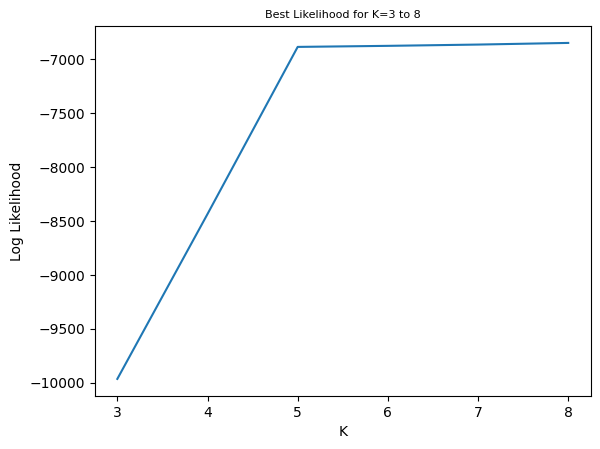

In [48]:
for datapath in datapaths:
    print(f"Running GMM for {datapath}")
    basename = os.path.basename(datapath).split('.')[0]
    if os.path.exists(os.path.join('figures', basename)):
        shutil.rmtree(os.path.join('figures', basename), ignore_errors=True)
    os.mkdir(os.path.join('figures', basename))
    best_likelihoods = []
    for k in range(3,9):
        best_likelihood = run_over_seeds(datapath, k)
        best_likelihoods.append(best_likelihood)
    plt.plot(range(3,9), best_likelihoods)
    plt.xlabel('K')
    plt.ylabel('Log Likelihood')
    plt.title(f'Best Likelihood for K=3 to 8', fontsize=8)
    plt.savefig(os.path.join('figures', basename, f'best_ll_vs_k' + '.png'), bbox_inches='tight', dpi=300)
    plt.close()
    print("----------------------------------")

In [56]:
def GMM_EM_GIF(X, K, max_iters):
    n, d = X.shape # n: number of data points, d: dimension of data points
    weights = np.random.rand(K) # These are the initial weights for the K GMM components, size (K,)
    weights = weights / np.sum(weights) # We normalize so they sum to 1
    # means = X[np.random.choice(n, K, replace=False)] # select K random points as initial means
    # Select K random points as initial means, points are selected randomly from min(X) to max(X)
    means = np.random.uniform(low=np.min(X), high=np.max(X), size=(K, d))
    # Initialize covariances as a diagonal matrix of random values between 0 and 1
    # covariances = [np.diag(np.random.rand(d)) for _ in range(K)]    
    covariances = [np.eye(d) for _ in range(K)]
    resp = np.zeros((n, K)) # These are the soft cluster assignments, initialized to zeros for now
    for iteration in range(max_iters):
        # E-step: Calculate responsibilities
        resp = np.zeros((n, K)) # Each element resp[i, k] represents the responsibility of cluster k for data point i
        for k in range(K):
            # dist = multivariate_normal(means[k], covariances[k]) # Create a multivariate normal distribution for this component
            pdf_X = 1 / np.sqrt(np.linalg.det(covariances[k]) * (2 * np.pi) ** d) * np.exp(-0.5 * np.sum((X - means[k]) * np.dot(np.linalg.inv(covariances[k]), (X - means[k]).T).T, axis=1))
            resp[:, k] = weights[k] * pdf_X # Calculate the responsibility of cluster k for all data points

        resp /= resp.sum(axis=1, keepdims=True) # Normalize responsibilities to sum to 1

        # M-step: Update parameters
        nk = resp.sum(axis=0) # The number of data points associated with each cluster. This is a vector of size (K,), since we have K clusters
        weights = nk / n # Fractions of the data points assigned to each cluster. Also a vector of size (K,)
        # Step 1: Matrix Multiplication
        weighted_sum = np.dot(resp.T, X)  # Shape: K x d

        # Step 2: Reshape nk
        nk_reshaped = nk[:, np.newaxis]  # Shape: K x 1

        # Step 3: Division
        means = weighted_sum / nk_reshaped  # Shape: K x d

        for k in range(K):
            diff = X - means[k]
            covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
            covariances[k] += 1e-6 * np.eye(d)
    # Compute assignments of data points to clusters
    # resp is a matrix of shape (n, K) containing the responsibility of each
    # cluster for each data point. We can get the cluster assignments by
    # using np.argmax to find the index of the cluster that has the max
    # responsibility for each data point.
    assignments = np.argmax(resp, axis=1)
    return weights, means, covariances, assignments, max_iters
    
def plot_all_model_contour_GIF(D, means, covs, assignments, seed, iterations, K, filename):
    plt.figure(figsize=(8, 6))
    plt.scatter(D[:,0], D[:,1], c=assignments, s=1)
    for k in range(K):
        plot_each_model_contour(D, means[k], covs[k])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'GMM with K={K} clusters, seed={str(hex(seed)).upper()}, max_iters={iterations}, dataset={os.path.basename(filename)}', fontsize=8)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

In [74]:
best_ks = [3, 5, 4, 5]
best_seeds = [0x2A, 0x1B, 0x1B, 0xDEADBEEF]
if os.path.exists(os.path.join('figures', 'animation')):
    shutil.rmtree(os.path.join('figures', 'animation'), ignore_errors=True)
os.mkdir(os.path.join('figures', 'animation'))
ITERS = 40
for datapath, best_k, best_seed in zip(datapaths, best_ks, best_seeds):
    print(f"Running GMM for {datapath}")
    basename = os.path.basename(datapath).split('.')[0]
    os.mkdir(os.path.join('figures', 'animation', basename))
    data = pd.read_csv(datapath).values
    data = compute_principle_components(data)
    for i in tqdm(range(1, ITERS, 2)):
        np.random.seed(best_seed)
        weights, means, covariances, assignments, iterations = GMM_EM_GIF(data, best_k, i)
        plot_all_model_contour_GIF(data, means, covariances, assignments, best_seed, ITERS, best_k, os.path.join('figures', 'animation', basename, f'gmm_K_{best_k}_iter_{i}.png'))
    print("----------------------------------")

Running GMM for data\2D_data_points_1.txt
Computing PCA for dataset of size (1499, 2)


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


----------------------------------
Running GMM for data\2D_data_points_2.txt
Computing PCA for dataset of size (3003, 2)


100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


----------------------------------
Running GMM for data\3D_data_points.txt
Computing PCA for dataset of size (1999, 3)


100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


----------------------------------
Running GMM for data\6D_data_points.txt
Computing PCA for dataset of size (2202, 6)


100%|██████████| 20/20 [00:32<00:00,  1.62s/it]

----------------------------------


In [75]:
import imageio
from PIL import Image
for datapath in datapaths:
    basename = os.path.basename(datapath).split('.')[0]
    files = sorted(glob.glob(os.path.join('figures', 'animation', basename, '*.png')), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))
    images = []
    for file in files:
        img = Image.open(file)
        img = img.resize((800, 600))
        images.append(img)
    imageio.mimsave(os.path.join('figures', f'{basename}.gif'), images, duration=0.5)
shutil.rmtree(os.path.join('figures', 'animation'), ignore_errors=True)

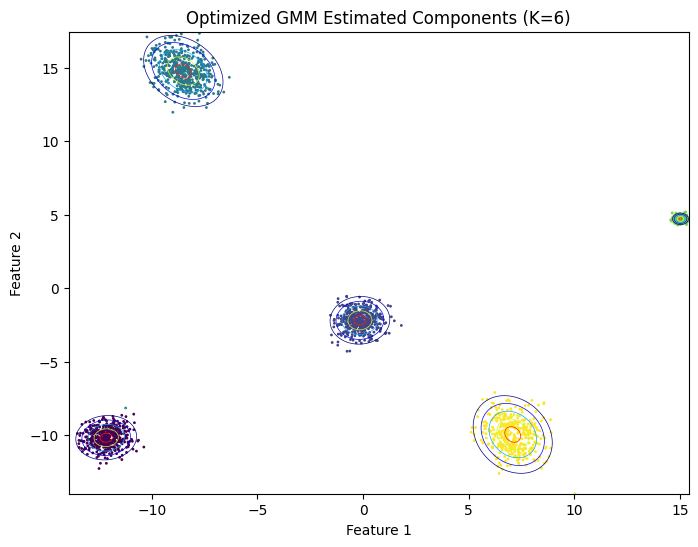

In [10]:

# Run optimized GMM EM for K=3 on the first dataset
data = compute_principle_components(datas[3])
K=6
np.random.seed(102)
weights, mean, cov, assignments, iterations = GMM_EM_optimized(data, K, max_iters=50)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], s=1, c=assignments)

for k in range(K):
    # Create grid for contour plot
    x, y = np.meshgrid(np.linspace(min(data[:,0]), max(data[:,0]), num=1000), 
                       np.linspace(min(data[:,1]), max(data[:,1]), num=1000))
    xy = np.column_stack([x.flat, y.flat])
    # z = multivariate_normal.pdf(xy, mean=means[k], cov=covariances[k])
    z = 1 / (2 * np.pi * np.sqrt(np.linalg.det(cov[k]))) * np.exp(-0.5 * np.sum(np.dot(xy - mean[k], np.linalg.inv(cov[k])) * (xy - mean[k]), axis=1))
    z = z.reshape(x.shape)
    levels = sorted(np.max(z)*np.exp(-0.5 * np.arange(0, 3, 0.5)**2))
    plt.contour(x, y, z, levels=levels, linewidths=0.5, cmap='jet')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Optimized GMM Estimated Components (K={K})')
plt.show()
